In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  1 15:51:49 2019

@author: jacob
"""

import h5py
import scipy.io as spio
#import mpl_toolkits.basemap 
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.patches as patches

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from ReadAtlantis_ALL import ReadAtlantis_ALL
from ReadAtlantis import ReadAtlantisSection
from ReadKnorr_ALL import ReadKnorr_ALL

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#%% LOAD SST MAP

filename = '/data/pacific/jacob/LATMIXDYE/SatData/AVHRR493data.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

sstdatafile=matfile['sstdata']

temp0 = sstdatafile[0]
temp1 = sstdatafile[1]
temp2 = sstdatafile[2]

sstdata = temp0.sst
sst=(sstdata.bytes-0.5)*sstdata.scale; 
sst[sst<0] = np.nan; 
sst=sst+sstdata.min

latgrid = temp0.subset.latgrid
longrid = temp0.subset.lonEgrid

latlimr = np.argmin(np.abs(latgrid-38))
latliml = np.argmin(np.abs(latgrid-40))
lonliml = np.argmin(np.abs(longrid+66))
lonlimr = np.argmin(np.abs(longrid+62))

#%% LOAD MET DATA

filename = '/data/pacific/jacob/LATMIXDYE/LATMIX/LES_COARE35_forcing.mat' # Front run
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

# List all groups
yearday = matfile['yearday']
tau_cs = matfile['tau_cs']
tau_d = matfile['tau_d']
qnet = matfile['net_heat_flux']
tmag = np.sqrt(tau_cs**2 + tau_d**2)

#%% LOAD FLOAT DATA
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons
#%% LOAD KNARR TRACK


filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

jday_ts = matfile['jday_ts']

latK = matfile['lat_ts']
lonK = matfile['lon_ts']


depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

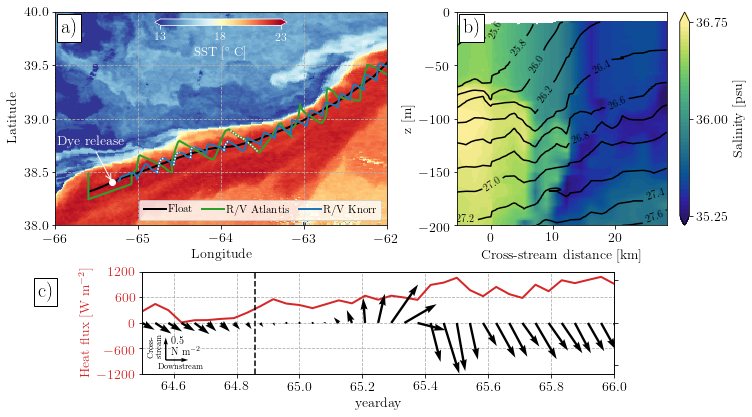

In [144]:
crossings = [4,  6, 8, 12]

# Get the sections used in the dye observatoinal plot
span = range(II[crossings[0],0], II[crossings[0],1])
latl1 = np.nanmean(lat[:,span],axis=0)
lonl1 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[1],0], II[crossings[1],1])
latl2 = np.nanmean(lat[:,span],axis=0)
lonl2 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[2],0], II[crossings[2],1])
latl3 = np.nanmean(lat[:,span],axis=0)
lonl3 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[3],0], II[crossings[3],1])
latl4 = np.nanmean(lat[:,span],axis=0)
lonl4 = np.nanmean(lon[:,span], axis=0)
#%% LOAD ATLANTIS TRACK
latA, lonA, timeA = ReadAtlantis_ALL()
sectdistA, zA, salA, rhoA, yeardayA, latAS, lonAS = ReadAtlantisSection(7) #7
zA  = -zA
#%%
cmap = 'RdYlBu_r'
tliml = 13
tlimh = 23

cols = 7

#fig = plt.figure(figsize=(12.22, 6.16))
fig = plt.figure(figsize=(12.22, 6.66))

# SST PLOT

aspratio = 1/np.cos(39*np.pi/180) # > 1 indicates x coordinate is smaller than y coordinate

axsst = plt.subplot2grid((20,cols), (0,0), rowspan = 12, colspan=4)
isst = axsst.pcolor(longrid[lonliml-1:lonlimr+1], latgrid[latliml-1:latlimr+1], np.transpose(sst[lonliml-1:lonlimr+1, latliml-1:latlimr+1]), cmap=cmap, vmin = tliml, vmax=tlimh)
isst.set_edgecolor('face')
axsst.plot(flons, flats, linewidth=2,  color='k', label='Float')
timeAind = np.argmin(np.abs(timeA - 64.86))
axsst.plot(lonA[timeAind:], latA[timeAind:], linewidth=2, color = '#2ca02c', label='R/V Atlantis')
#axsst.plot(lonAS[0], latAS[0], linewidth=1, color='#2ca02c', marker='o')  #Highlight Atlantis Section
#axsst.plot(lonAS[-1], latAS[-1], linewidth=1, color='#2ca02c', marker='o')  #Highlight Atlantis Section
l1, = axsst.plot(lonAS, latAS, color='w', linestyle='dashed')
l1.set_dashes([1, 1])
           
axsst.plot(lonK, latK, linewidth=2, color = '#1f77b4', label='R/V Knorr')
# mark Knorr sections used
l1, = axsst.plot(lonl1, latl1, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])

l1, = axsst.plot(lonl2, latl2, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])
    
l1, = axsst.plot(lonl3, latl3, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])

l1, = axsst.plot(lonl4, latl4, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])
                                        
indrelease = np.argmin(np.abs(fyds - 64.86))
axsst.plot(flons[indrelease], flats[indrelease], marker='o', color='w')
axsst.annotate('Dye release', xytext=(-65.975, 38.75), xy=(flons[indrelease], flats[indrelease]), color='w',
            arrowprops=dict(arrowstyle='->', color='w'),
            )
cbaxes = inset_axes(axsst, width="40%", height="3%", loc=9) 
cb = plt.colorbar(isst, cax=cbaxes, orientation='horizontal', extend='both')
cb.set_label('SST [$^{\circ}$ C]', color='w', fontsize=13)
cb.outline.set_edgecolor('w')
cb.set_ticks([tliml, (tlimh-tliml)/2+tliml, tlimh])
cb.ax.xaxis.set_tick_params(color='w')
cb.ax.tick_params(labelsize=12)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w') # set colorbar  
axsst.text( -65.93, 39.8 ,'a)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))
#plt.colorbar(isst, cax = axsst)
axsst.set_xlim(-66, -62)
axsst.set_ylim(38, 40)
axsst.set_aspect(aspratio)
axsst.set_ylabel('Latitude')
axsst.set_xlabel('Longitude')
axsst.grid(linestyle='dashed')
axsst.legend(loc=4, ncol=3, fontsize=11, handletextpad=0.2, columnspacing=0.8)


# SURFACE FORCING PLOT
axflux = plt.subplot2grid((20,cols), (14,1), rowspan=6, colspan=cols-2)


color = 'tab:red'
axflux.plot(yearday, qnet, color=color, linewidth=2)
axflux.set_ylim(-1200,1200)
axflux.set_xlim(64.5, 66)
axflux.grid(linestyle='dashed')
axflux.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
axflux.tick_params(axis='y', labelcolor=color)
axflux.set_yticks([-1200, -600, 0, 600, 1200])
axflux.set_xlabel('yearday')
axflux.axvline(64.86, color='k', linestyle='--')
axflux.text( -0.22, 0.75 ,'c)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'),transform=axflux.transAxes )

axwind = axflux.twinx()
axwind.set_yticklabels([])
# Quiver plot of wind stress
q = axwind.quiver(yearday, 0*yearday, tau_d, tau_cs, scale=10.5, width=5e-3)

# Add a legend for the quiver plot magnitude
#axwind.quiverkey(q, 64.995, -1000, 0.5, 'Down-\nstream', coordinates='data', labelpos='S', fontproperties={'size': 10})
#axwind.quiverkey(q, 64.94, -790, 0.5, 'Cross-\nstream', coordinates='data',labelpos='W', angle=90, labelsep=0.05, fontproperties={'size': 10})
off = 0.36
axwind.text(64.952 - off, -745, '0.5\nN m$^{-2}$', fontsize=10, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
axwind.quiver(64.935-off, -870, 0.5, 0., scale=10.5, width=3e-3)
axwind.quiver(64.935-off, -870, 0., 0.5, scale=10.5, width=3e-3)
axwind.text(64.88-off, -810, 'Cross-\nstream', fontsize=8, rotation=90)
axwind.text(64.91-off, -1110, 'Downstream', fontsize=8, rotation=0, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

axwind.set_ylim(-1200, 1200)
    


# SALINITY SECTION
axSal = plt.subplot2grid((20,cols), (0,4), colspan=cols-4, rowspan=12)

cmapsal = cmo.haline
#cmapsal = 'RdYlBu_r'
conts = np.linspace(35.25, 36.75, 50)
im = axSal.contourf(sectdistA, zA, salA, conts, extend='both',cmap=cmapsal)
for c in im.collections:
    c.set_edgecolor("face")
cb = plt.colorbar(im, ax=axSal)
cb.set_ticks((conts[0], 36, conts[-1]))
cb.solids.set_edgecolor("face")
cb.set_label('Salinity [psu]')

rhoc = np.linspace(1025, 1028, 16)
cs = axSal.contour(sectdistA, zA, rhoA-1000, rhoc-1000, colors='k')
axSal.clabel(cs, cs.levels[::1], inline=1, fontsize=10, fmt='%1.1f')
axSal.set_ylim((-200, 0))
axSal.set_ylabel('z [m]')
axSal.set_xlabel('Cross-stream distance [km]')
#axSal.axvline(sectdistA[14])
axSal.text( -4.5, -20 ,'b)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

plt.subplots_adjust(wspace=1, hspace=1)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/ObsOverview.pdf', bbox_inches='tight')

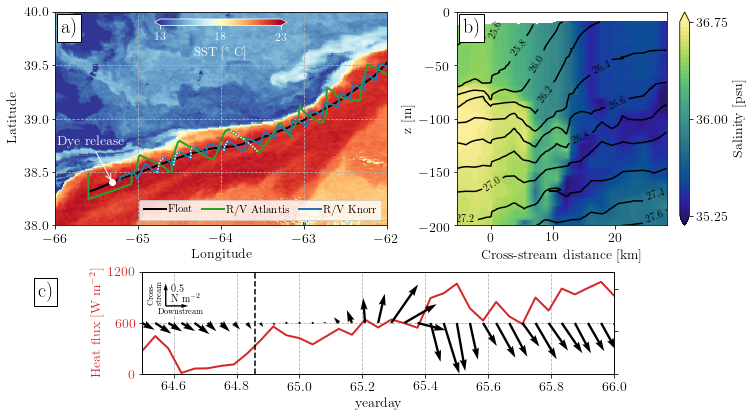

In [155]:
# ALTERNATE FLUX LIMITS

crossings = [4,  6, 8, 12]

# Get the sections used in the dye observatoinal plot
span = range(II[crossings[0],0], II[crossings[0],1])
latl1 = np.nanmean(lat[:,span],axis=0)
lonl1 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[1],0], II[crossings[1],1])
latl2 = np.nanmean(lat[:,span],axis=0)
lonl2 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[2],0], II[crossings[2],1])
latl3 = np.nanmean(lat[:,span],axis=0)
lonl3 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[3],0], II[crossings[3],1])
latl4 = np.nanmean(lat[:,span],axis=0)
lonl4 = np.nanmean(lon[:,span], axis=0)
#%% LOAD ATLANTIS TRACK
latA, lonA, timeA = ReadAtlantis_ALL()
sectdistA, zA, salA, rhoA, yeardayA, latAS, lonAS = ReadAtlantisSection(7) #7
zA  = -zA
#%%
cmap = 'RdYlBu_r'
tliml = 13
tlimh = 23

cols = 7

#fig = plt.figure(figsize=(12.22, 6.16))
fig = plt.figure(figsize=(12.22, 6.66))

# SST PLOT

aspratio = 1/np.cos(39*np.pi/180) # > 1 indicates x coordinate is smaller than y coordinate

axsst = plt.subplot2grid((20,cols), (0,0), rowspan = 12, colspan=4)
isst = axsst.pcolor(longrid[lonliml-1:lonlimr+1], latgrid[latliml-1:latlimr+1], np.transpose(sst[lonliml-1:lonlimr+1, latliml-1:latlimr+1]), cmap=cmap, vmin = tliml, vmax=tlimh)
isst.set_edgecolor('face')
axsst.plot(flons, flats, linewidth=2,  color='k', label='Float')
timeAind = np.argmin(np.abs(timeA - 64.86))
axsst.plot(lonA[timeAind:], latA[timeAind:], linewidth=2, color = '#2ca02c', label='R/V Atlantis')
#axsst.plot(lonAS[0], latAS[0], linewidth=1, color='#2ca02c', marker='o')  #Highlight Atlantis Section
#axsst.plot(lonAS[-1], latAS[-1], linewidth=1, color='#2ca02c', marker='o')  #Highlight Atlantis Section
l1, = axsst.plot(lonAS, latAS, color='w', linestyle='dashed')
l1.set_dashes([1, 1])
           
axsst.plot(lonK, latK, linewidth=2, color = '#1f77b4', label='R/V Knorr')
# mark Knorr sections used
l1, = axsst.plot(lonl1, latl1, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])

l1, = axsst.plot(lonl2, latl2, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])
    
l1, = axsst.plot(lonl3, latl3, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])

l1, = axsst.plot(lonl4, latl4, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])
                                        
indrelease = np.argmin(np.abs(fyds - 64.86))
axsst.plot(flons[indrelease], flats[indrelease], marker='o', color='w')
axsst.annotate('Dye release', xytext=(-65.975, 38.75), xy=(flons[indrelease], flats[indrelease]), color='w',
            arrowprops=dict(arrowstyle='->', color='w'),
            )
cbaxes = inset_axes(axsst, width="40%", height="3%", loc=9) 
cb = plt.colorbar(isst, cax=cbaxes, orientation='horizontal', extend='both')
cb.set_label('SST [$^{\circ}$ C]', color='w', fontsize=13)
cb.outline.set_edgecolor('w')
cb.set_ticks([tliml, (tlimh-tliml)/2+tliml, tlimh])
cb.ax.xaxis.set_tick_params(color='w')
cb.ax.tick_params(labelsize=12)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w') # set colorbar  
axsst.text( -65.93, 39.8 ,'a)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))
#plt.colorbar(isst, cax = axsst)
axsst.set_xlim(-66, -62)
axsst.set_ylim(38, 40)
axsst.set_aspect(aspratio)
axsst.set_ylabel('Latitude')
axsst.set_xlabel('Longitude')
axsst.grid(linestyle='dashed')
axsst.legend(loc=4, ncol=3, fontsize=11, handletextpad=0.2, columnspacing=0.8)


# SURFACE FORCING PLOT
axflux = plt.subplot2grid((20,cols), (14,1), rowspan=6, colspan=cols-2)


color = 'tab:red'
axflux.plot(yearday, qnet, color=color, linewidth=2)
axflux.set_ylim(-0,1200)
axflux.set_xlim(64.5, 66)
axflux.grid(linestyle='dashed')
axflux.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
axflux.tick_params(axis='y', labelcolor=color)
axflux.set_yticks([ 0, 600, 1200])
axflux.set_xlabel('yearday')
axflux.axvline(64.86, color='k', linestyle='--')
axflux.text( -0.22, 0.75 ,'c)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'),transform=axflux.transAxes )

axwind = axflux.twinx()
axwind.set_yticklabels([])
# Quiver plot of wind stress
q = axwind.quiver(yearday, 600+0*yearday, tau_d, tau_cs, scale=10.5, width=5e-3)

# Add a legend for the quiver plot magnitude
#axwind.quiverkey(q, 64.995, -1000, 0.5, 'Down-\nstream', coordinates='data', labelpos='S', fontproperties={'size': 10})
#axwind.quiverkey(q, 64.94, -790, 0.5, 'Cross-\nstream', coordinates='data',labelpos='W', angle=90, labelsep=0.05, fontproperties={'size': 10})
off = 0.36
axwind.text(64.952 - off, 850, '0.5\nN m$^{-2}$', fontsize=10, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
axwind.quiver(64.935-off, 800, 0.5, 0., scale=10.5, width=3e-3)
axwind.quiver(64.935-off, 800, 0., 0.5, scale=10.5, width=3e-3)
axwind.text(64.88-off, 820, 'Cross-\nstream', fontsize=8, rotation=90)
axwind.text(64.91-off, 700, 'Downstream', fontsize=8, rotation=0, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

axwind.set_ylim(-0, 1200)
    


# SALINITY SECTION
axSal = plt.subplot2grid((20,cols), (0,4), colspan=cols-4, rowspan=12)

cmapsal = cmo.haline
#cmapsal = 'RdYlBu_r'
conts = np.linspace(35.25, 36.75, 50)
im = axSal.contourf(sectdistA, zA, salA, conts, extend='both',cmap=cmapsal)
for c in im.collections:
    c.set_edgecolor("face")
cb = plt.colorbar(im, ax=axSal)
cb.set_ticks((conts[0], 36, conts[-1]))
cb.solids.set_edgecolor("face")
cb.set_label('Salinity [psu]')

rhoc = np.linspace(1025, 1028, 16)
cs = axSal.contour(sectdistA, zA, rhoA-1000, rhoc-1000, colors='k')
axSal.clabel(cs, cs.levels[::1], inline=1, fontsize=10, fmt='%1.1f')
axSal.set_ylim((-200, 0))
axSal.set_ylabel('z [m]')
axSal.set_xlabel('Cross-stream distance [km]')
#axSal.axvline(sectdistA[14])
axSal.text( -4.5, -20 ,'b)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

plt.subplots_adjust(wspace=1, hspace=1)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/ObsOverview.pdf', bbox_inches='tight')

In [142]:
def getDistance(lat, lon, startlat, startlon):
          latdeg = lat*np.pi/180
          londeg = lon*np.pi/180
          startlatdeg = startlat*np.pi/180
          startlondeg = startlon*np.pi/180
          
          d=2*np.arcsin(np.sqrt((np.sin((startlatdeg-latdeg)/2))**2 + 
                     np.cos(startlatdeg)*np.cos(latdeg)*(np.sin((startlondeg-londeg)/2))**2))
          dkm = 2*np.pi*6356.752*d/(2*np.pi)*np.sign(latdeg-startlatdeg)
          return dkm
    
mindist = 1e10    
mindex = np.nan
for i in range(0, sectdistA.size):
    floatdist = getDistance(flat, flon, latAS[i], lonAS[i])
    minfloatd = np.min(np.abs(floatdist))
    #print(minfloatd)
    if minfloatd<mindist:
        mindist = minfloatd
        mindex = i

mindex 

mindist

1.4403094822962907

In [137]:
minfloatd

12.268729243142747

In [ ]:
# ORIGINAL FIGURE
crossings = [4,  6, 8, 12]

# Get the sections used in the dye observatoinal plot
span = range(II[crossings[0],0], II[crossings[0],1])
latl1 = np.nanmean(lat[:,span],axis=0)
lonl1 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[1],0], II[crossings[1],1])
latl2 = np.nanmean(lat[:,span],axis=0)
lonl2 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[2],0], II[crossings[2],1])
latl3 = np.nanmean(lat[:,span],axis=0)
lonl3 = np.nanmean(lon[:,span], axis=0)

span = range(II[crossings[3],0], II[crossings[3],1])
latl4 = np.nanmean(lat[:,span],axis=0)
lonl4 = np.nanmean(lon[:,span], axis=0)
#%% LOAD ATLANTIS TRACK
latA, lonA, timeA = ReadAtlantis_ALL()
sectdistA, zA, salA, rhoA, yeardayA, latAS, lonAS = ReadAtlantisSection(7) #7
zA  = -zA
#%%
cmap = 'RdYlBu_r'
tliml = 13
tlimh = 23

cols = 7

fig = plt.figure(figsize=(12.22, 6.16))

# SST PLOT

aspratio = 1/np.cos(39*np.pi/180) # > 1 indicates x coordinate is smaller than y coordinate

axsst = plt.subplot2grid((3,cols), (0,0), rowspan = 2, colspan=4)
isst = axsst.pcolor(longrid[lonliml-1:lonlimr+1], latgrid[latliml-1:latlimr+1], np.transpose(sst[lonliml-1:lonlimr+1, latliml-1:latlimr+1]), cmap=cmap, vmin = tliml, vmax=tlimh)
isst.set_edgecolor('face')
axsst.plot(flons, flats, linewidth=2,  color='k', label='Float')
timeAind = np.argmin(np.abs(timeA - 64.86))
axsst.plot(lonA[timeAind:], latA[timeAind:], linewidth=2, color = '#2ca02c', label='R/V Atlantis')
#axsst.plot(lonAS[0], latAS[0], linewidth=1, color='#2ca02c', marker='o')  #Highlight Atlantis Section
#axsst.plot(lonAS[-1], latAS[-1], linewidth=1, color='#2ca02c', marker='o')  #Highlight Atlantis Section
l1, = axsst.plot(lonAS, latAS, color='w', linestyle='dashed')
l1.set_dashes([1, 1])
           
axsst.plot(lonK, latK, linewidth=2, color = '#1f77b4', label='R/V Knorr')
# mark Knorr sections used
l1, = axsst.plot(lonl1, latl1, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])

l1, = axsst.plot(lonl2, latl2, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])
    
l1, = axsst.plot(lonl3, latl3, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])

l1, = axsst.plot(lonl4, latl4, color = 'w', linestyle='dashed')
l1.set_dashes([1, 1])
                                        
indrelease = np.argmin(np.abs(fyds - 64.86))
axsst.plot(flons[indrelease], flats[indrelease], marker='o', color='w')
axsst.annotate('Dye release', xytext=(-65.975, 38.75), xy=(flons[indrelease], flats[indrelease]), color='w',
            arrowprops=dict(arrowstyle='->', color='w'),
            )
cbaxes = inset_axes(axsst, width="40%", height="3%", loc=9) 
cb = plt.colorbar(isst, cax=cbaxes, orientation='horizontal', extend='both')
cb.set_label('SST [$^{\circ}$ C]', color='w', fontsize=13)
cb.outline.set_edgecolor('w')
cb.set_ticks([tliml, (tlimh-tliml)/2+tliml, tlimh])
cb.ax.xaxis.set_tick_params(color='w')
cb.ax.tick_params(labelsize=12)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w') # set colorbar  
axsst.text( -65.93, 39.8 ,'a)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))
#plt.colorbar(isst, cax = axsst)
axsst.set_xlim(-66, -62)
axsst.set_ylim(38, 40)
axsst.set_aspect(aspratio)
axsst.set_ylabel('Latitude')
axsst.set_xlabel('Longitude')
axsst.grid(linestyle='dashed')
axsst.legend(loc=4, ncol=3, fontsize=11, handletextpad=0.2, columnspacing=0.8)


# SURFACE FORCING PLOT
axflux = plt.subplot2grid((3,cols), (2,1), colspan=cols-2)
color = 'tab:blue'
axflux.plot(yearday, tmag, color=color, linewidth=2)
axflux.tick_params(axis='y', labelcolor=color)
axflux.set_ylabel('Wind-stress\n magnitude\n [N m$^{-2}$]', color=color)  # we already handled the x-label with ax1
axflux.set_ylim((0, 1.2))
axflux.set_yticks([0, 0.3, 0.6, 0.9,  1.2])
axflux.set_xlim((64.5, 66))
axflux.set_xlabel('yearday')

axflux2 = axflux.twinx()
axflux.axvline(64.86, linestyle='dashed', color='k')
color = 'tab:red'
axflux2.plot(yearday, qnet, color=color, linewidth=2)
axflux2.set_ylabel('Net surface\n heat flux\n [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
axflux2.tick_params(axis='y', labelcolor=color)
axflux2.set_ylim((0, 1200))
axflux2.set_yticks([0, 300, 600, 900,  1200])
axflux.grid(linestyle='dashed')
axflux.text( -0.22, 0.75 ,'c)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'),transform=axflux.transAxes )

# SALINITY SECTION
axSal = plt.subplot2grid((3,cols), (0,4), colspan=cols-4, rowspan=2)

cmapsal = cmo.haline
#cmapsal = 'RdYlBu_r'
conts = np.linspace(35.25, 36.75, 50)
im = axSal.contourf(sectdistA, zA, salA, conts, extend='both',cmap=cmapsal)
for c in im.collections:
    c.set_edgecolor("face")
cb = plt.colorbar(im, ax=axSal)
cb.set_ticks((conts[0], 36, conts[-1]))
cb.solids.set_edgecolor("face")
cb.set_label('Salinity [psu]')

rhoc = np.linspace(1025, 1028, 21)
axSal.contour(sectdistA, zA, rhoA, rhoc, colors='k')
axSal.set_ylim((-200, 0))
axSal.set_ylabel('z [m]')
axSal.set_xlabel('Cross-stream distance [km]')

axSal.text( -4.5, -20 ,'b)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

plt.subplots_adjust(wspace=1, hspace=0.7)

#plt.savefig('/home/jacob/Dropbox/GulfStreamDye/LATMIXSCIENCE/ObsOverview.pdf', bbox_inches='tight')

array([[0.0931763 , 0.11117333, 0.26151239, 1.        ],
       [0.09697152, 0.11687021, 0.27309631, 1.        ],
       [0.10096885, 0.12239315, 0.28491036, 1.        ],
       [0.1049927 , 0.12782437, 0.29687381, 1.        ],
       [0.1089874 , 0.1331935 , 0.30895384, 1.        ],
       [0.1129223 , 0.13851314, 0.32115284, 1.        ],
       [0.11677874, 0.14379072, 0.33347631, 1.        ],
       [0.12054634, 0.14903305, 0.34591927, 1.        ],
       [0.12421597, 0.1542449 , 0.35848249, 1.        ],
       [0.12777784, 0.1594293 , 0.37117372, 1.        ],
       [0.13122438, 0.16458993, 0.3839939 , 1.        ],
       [0.13454904, 0.16973078, 0.39694025, 1.        ],
       [0.13774403, 0.17485525, 0.41001322, 1.        ],
       [0.14079963, 0.17996609, 0.42321738, 1.        ],
       [0.14370728, 0.18506718, 0.43655022, 1.        ],
       [0.14645608, 0.19016193, 0.4500131 , 1.        ],
       [0.14903482, 0.19525448, 0.46360362, 1.        ],
       [0.15143093, 0.20034937,

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


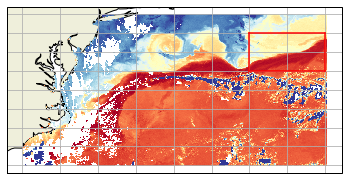

In [4]:
#%% OVERVIEW OF WHOLE SATELLITE
latgrid = temp0.subset.latgrid
longrid = temp0.subset.lonEgrid
sstdata = temp0.sst
sst=(sstdata.bytes-0.5)*sstdata.scale; 
sst[sst<0] = np.nan; 
sst=sst+sstdata.min

tliml = 5
tlimh = 23

fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-45, 45))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.pcolormesh(longrid, latgrid, np.transpose(sst), cmap=cmap, vmin = tliml, vmax=tlimh, transform = ccrs.PlateCarree())

#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor='black')
#
#ax.set_global()
ax.gridlines()



tf = ccrs.Geodetic()
ax.plot([-66, -62], [38, 38],
         color='r', linestyle='-',
         transform=tf,
         )
ax.plot([-66, -62], [40, 40],
         color='r', linestyle='-',
         transform=tf,
         )
ax.plot([-66, -66], [38, 40],
         color='r', linestyle='-',
         transform=tf,
         )
ax.plot([-62, -62], [38, 40],
         color='r', linestyle='-',
         transform=tf,
         )

#%%
import sys
np.set_printoptions(threshold=sys.maxsize)
cmo.balance(np.linspace(0,1,255))